In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

/home/dotrungkien/anaconda2/envs/py36-conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/chars74K/characters'

In [4]:
!ls data/chars74K

characters	EnglishHnd.tgz	FullImagesAndAnnotations_Frontal.tgz
EnglishFnt.tgz	EnglishImg.tgz


In [14]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255.)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 36))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size] = features_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: break
    return features, labels

train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)
test_features, test_labels = extract_features(test_dir, 3000)

Found 36576 images belonging to 36 classes.
Found 5795 images belonging to 36 classes.
Found 3358 images belonging to 36 classes.


In [16]:
train_features = np.reshape(train_features, (20000, 4*4*512))
validation_features = np.reshape(validation_features, (5000, 4*4*512))
test_features = np.reshape(test_features, (3000, 4*4*512))

In [17]:
print(train_features.shape, train_labels.shape)

(20000, 8192) (20000, 36)


In [18]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(36, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 3s 169us/step - loss: 2.1188 - acc: 0.5204 - val_loss: 2.3765 - val_acc: 0.4700
Epoch 2/30
20000/20000 [==============================] - 3s 158us/step - loss: 0.8358 - acc: 0.8314 - val_loss: 2.0135 - val_acc: 0.5024
Epoch 3/30
20000/20000 [==============================] - 3s 165us/step - loss: 0.5464 - acc: 0.8816 - val_loss: 1.8641 - val_acc: 0.5296
Epoch 4/30
20000/20000 [==============================] - 3s 169us/step - loss: 0.4279 - acc: 0.8996 - val_loss: 1.7746 - val_acc: 0.5374
Epoch 5/30
20000/20000 [==============================] - 3s 158us/step - loss: 0.3576 - acc: 0.9140 - val_loss: 1.7360 - val_acc: 0.5360
Epoch 6/30
20000/20000 [==============================] - 3s 159us/step - loss: 0.3165 - acc: 0.9201 - val_loss: 1.6630 - val_acc: 0.5500
Epoch 7/30
20000/20000 [==============================] - 3s 170us/step - loss: 0.2825 - acc: 0.9274 - val_loss: 1.6608 - v

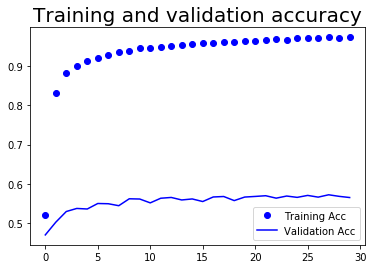

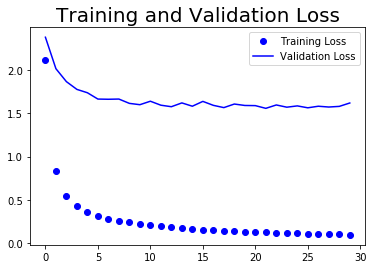

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.legend()

plt.show()

In [22]:
from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 36)                9252      
Total params: 16,821,348
Trainable params: 16,821,348
Non-trainable params: 0
_________________________________________________________________


In [24]:
len(model.trainable_weights)

30

In [25]:
conv_base.trainable = False

In [26]:
len(model.trainable_weights)

4

In [33]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 50

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_features.shape[0]//batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Found 36576 images belonging to 36 classes.
Found 5795 images belonging to 36 classes.
Epoch 1/30
400/400 [==============================] - 64s 160ms/step - loss: 0.7646 - acc: 0.8200 - val_loss: 1.9842 - val_acc: 0.4988
Epoch 2/30
400/400 [==============================] - 66s 164ms/step - loss: 0.7006 - acc: 0.8324 - val_loss: 1.9766 - val_acc: 0.4948
Epoch 3/30
400/400 [==============================] - 72s 180ms/step - loss: 0.6602 - acc: 0.8410 - val_loss: 1.9525 - val_acc: 0.4950
Epoch 4/30
400/400 [==============================] - 65s 162ms/step - loss: 0.6154 - acc: 0.8497 - val_loss: 1.9192 - val_acc: 0.5068
Epoch 5/30
400/400 [==============================] - 65s 163ms/step - loss: 0.5887 - acc: 0.8521 - val_loss: 1.9613 - val_acc: 0.4970
Epoch 6/30
400/400 [==============================] - 63s 157ms/step - loss: 0.5623 - acc: 0.8593 - val_loss: 1.8967 - val_acc: 0.5020
Epoch 7/30
400/400 [==============================] - 63s 158ms/step - loss: 0.5413 - acc: 0.8616 - val

KeyboardInterrupt: 

In [34]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
    else:
        layer.trainable = False
        
        
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 21s 208ms/step - loss: 0.3172 - acc: 0.9084 - val_loss: 1.8706 - val_acc: 0.5384
Epoch 2/30
100/100 [==============================] - 18s 182ms/step - loss: 0.3300 - acc: 0.9076 - val_loss: 1.8760 - val_acc: 0.5496
Epoch 3/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2904 - acc: 0.9118 - val_loss: 1.8172 - val_acc: 0.5431
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.2947 - acc: 0.9126 - val_loss: 1.9821 - val_acc: 0.5200
Epoch 5/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2945 - acc: 0.9172 - val_loss: 1.9164 - val_acc: 0.5435
Epoch 6/30
100/100 [==============================] - 19s 188ms/step - loss: 0.2768 - acc: 0.9152 - val_loss: 1.9185 - val_acc: 0.5208
Epoch 7/30
100/100 [==============================] - 19s 190ms/step - loss: 0.2932 - acc: 0.9114 - val_loss: 1.8855 - val_acc: 0.5383
Epoch 8/30
100/100 [==============================] - 1

In [36]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
test_loss, test_acc

Found 3358 images belonging to 36 classes.


(3.7900803661346436, 0.33300000250339507)